In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBRegressor

Read Files and PreProcess

In [7]:
df = pd.read_csv(r'./train.csv')
df_test = pd.read_csv(r'./test.csv')

# Preprocess department
print("Preprocess department\n""BEFORE:")
print(df.department.value_counts())
print(df_test.department.value_counts())
df=df.replace(['finishing '], ['finishing']) # 去除多餘空格
df_test=df_test.replace(['finishing '], ['finishing']) # 去除多餘空白
print("---------------------\nAFTER:")
print(df.department.value_counts())
print(df_test.department.value_counts())

# PreProcess wip
print("=====================")
print("Preprocess wip\n""BEFORE:")
print(df.isna().sum())
print(df_test.isna().sum())
df['wip'].fillna(0,inplace=True) # 空白處填 0
df_test['wip'].fillna(0,inplace=True) # 空白處填 0
df['wip'].fillna(df['wip'].median(),inplace=True) # 空白處填 mid
df_test['wip'].fillna(df_test['wip'].median(),inplace=True) # 空白處填 mid
print("---------------------\nAFTER:")
print(df.isna().sum())
print(df_test.isna().sum())

Preprocess department
BEFORE:
sweing        561
finishing     257
finishing     139
Name: department, dtype: int64
sweing       130
finishing    110
Name: department, dtype: int64
---------------------
AFTER:
sweing       561
finishing    396
Name: department, dtype: int64
sweing       130
finishing    110
Name: department, dtype: int64
Preprocess wip
BEFORE:
date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      396
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64
date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv             

Adding Feature

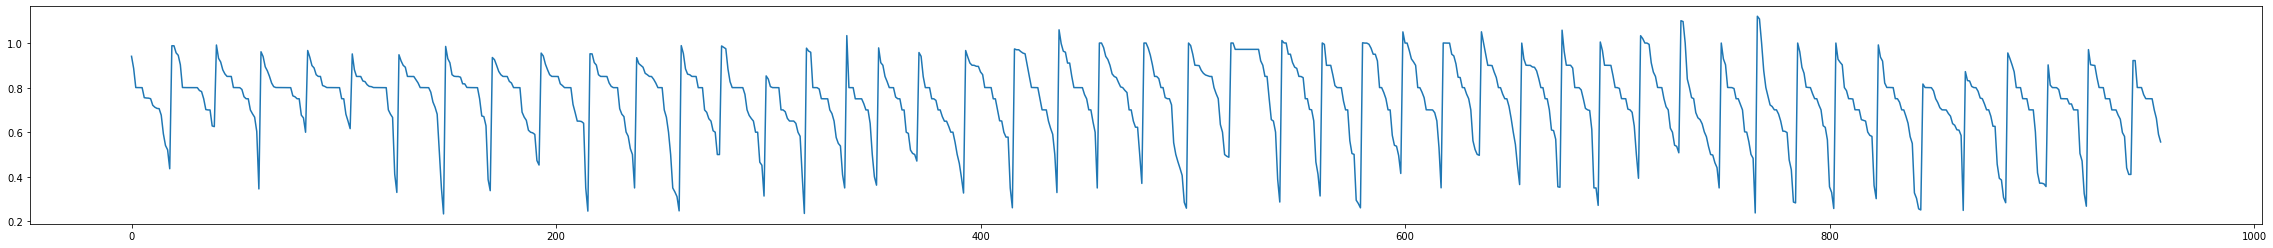

In [8]:
# Finding feature
fig=plt.figure()
plt.plot(df['actual_productivity'])
plt.rcParams["figure.figsize"] = (16, 4)
fig.set_figheight(4)
fig.set_figwidth(40)
plt.show()

# Adding column for the special pattern
count=1
temp_date=1
temp_array=[]
for i in df.index:
    if temp_date!=df['date'][i]:
        temp_array.append(1)
        count=2
        temp_date=df['date'][i]
    else:
        temp_array.append(count)
        count+=1
df['rule']=temp_array
count=1
temp_date=1
temp_array=[]
for i in df_test.index:
    if temp_date!=df_test['date'][i]:
        temp_array.append(1)
        count=2
        temp_date=df_test['date'][i]
    else:
        temp_array.append(count)
        count+=1
countForFeb26=15
for j in df_test.index:
    if df_test['date'][j]=="2/26/2015":
        temp_array[j]=countForFeb26
        countForFeb26+=1
df_test['rule']=temp_array

Others Data PreProcess

In [9]:
# One Hot Encoding for categorical columns
def create_dummies(dataframe, column_name):
    dummies = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, dummies], axis=1)
    return dataframe

df = create_dummies(df,"quarter")
df = create_dummies(df,"department")
df = create_dummies(df,"day")
df = create_dummies(df,"team")
df_test = create_dummies(df_test,"quarter")
df_test = create_dummies(df_test,"department")
df_test = create_dummies(df_test,"day")
df_test = create_dummies(df_test,"team")
df=df.drop(['quarter', 'department', 'day', 'team'],axis=1)
df_test=df_test.drop(['quarter', 'department', 'day', 'team'],axis=1)

# Labeling
le = LabelEncoder()
df["no_of_style_change"] = le.fit_transform(df["no_of_style_change"])
df['date'] = le.fit_transform(df['date'])
df_test["no_of_style_change"] = le.fit_transform(df_test["no_of_style_change"])
df_test['date'] = le.fit_transform(df_test['date'])

# Final Adjustment
df = df.reindex(sorted(df.columns), axis=1)
y = df['actual_productivity']
X = df.loc[:, df.columns != 'actual_productivity']
df_test['quarter_Quarter3'], df_test['quarter_Quarter5']=0,0
df_test = df_test.reindex(sorted(df_test.columns), axis=1)
X_test = df_test[df_test.columns]

# Numerical Variable
scaler = MinMaxScaler()
# scaler = Normalizer()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

Tuning Model

In [10]:
# from sklearn.model_selection import GridSearchCV
#
# params = { 'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
#            'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
#            'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
#            'n_estimators': [100, 300, 500],
#            'min_child_weight': [ 1, 3, 5, 7 ]}
# xgbr = XGBRegressor(seed = 20)
# clf = GridSearchCV(estimator=xgbr,
#                    param_grid=params,
#                    scoring='neg_mean_squared_error',
#                    verbose=1)
# clf.fit(X_scaled, y)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 300}
Lowest RMSE:  0.07768063946461387


Training and Testing

rms: 0.09165399961308096


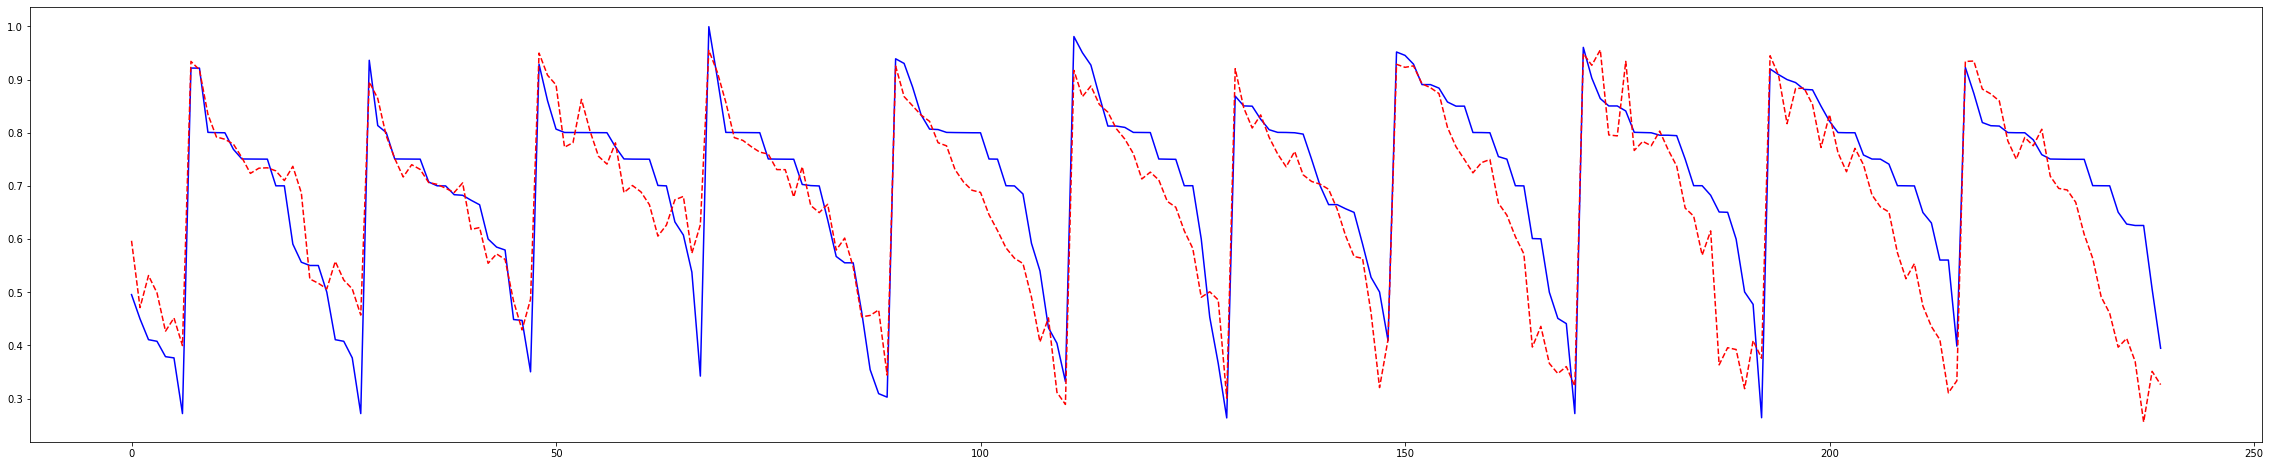

In [14]:
from sklearn.metrics import mean_squared_error

# Training with XGBoost
xgb=XGBRegressor(colsample_bytree=0.5,
                 learning_rate=.05,
                 max_depth=6,
                 min_child_weight=7,
                 n_estimators=300,
                 objective='reg:squarederror')

# Predict test data
xgb.fit(X_scaled, y)
y_pred = xgb.predict(X_test_scaled)

# Visualization and Output CSV
df_ans = pd.DataFrame(y_pred.astype(float), columns=['actual_productivity'])
df_ans.to_csv('mySubmission.csv', index_label='Id')
df_ans = pd.read_csv(r'./mySubmission.csv')
fig=plt.figure()
df_actual_ans = pd.read_csv(r'./ans.csv')
plt.plot(df_actual_ans['actual_productivity'], 'b')
plt.plot(df_ans['actual_productivity'], 'r--')
rms = np.sqrt(mean_squared_error(df_actual_ans['actual_productivity'], y_pred))
print("rms:",rms)
plt.rcParams["figure.figsize"] = (16, 8)
fig.set_figwidth(40)
fig.set_figheight(8)
plt.show()

In [12]:
# score = np.sqrt(-cross_val_score(xgb, X_scaled, y, cv = 5, scoring = 'neg_mean_squared_error'))
# print("R2: %0.4f (std: %0.4f)" % (score.mean(), score.std()))
# scores = cross_validate(xgb, X_scaled, y, cv=5, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
# print("====================================")
# print("R2: %0.4f (std: %0.4f)" % (scores['test_r2'].mean(), scores['test_r2'].std()))
# print("MSE: %0.4f (std: %0.4f)" % (-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
# print("MAPE: %0.4f (std: %0.4f)" % (-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))